# Modeling complex biological systems and using evolutionary algorithms to learn their parameters from heterogenous data

## A teaser of things to come:

<img src = './161105_ea_test_1000runs/161103_best_anim_001_small.gif'/> 
<img src = 'https://github.com/jeffmsnell/modelingEA/blob/master/161103_best_anim_001_small.gif'>

In [14]:
from IPython.display import Image
Image(url='https://github.com/jeffmsnell/modelingEA/blob/master/161103_best_anim_001_small.gif')

## Introduction

**Our overarching goal here is two-fold:** 
1. Mathematically and computationally model the dynamics of complex biological systems. Here we will achieve this with ordinary differential equations.  
2. Learn unknown or unmeasurable parameters from highly heterogenous datasets. Here we will achieve this with genetic or evolutionary algorithms (EA).    
 
Our simple model is a three cell system, where each cell has unique properties. We can describe the system graphically:    
<img src = './images/simple_model_2nf_1.jpg'/>  

And we can describe it textually:  
- Cell A has properties of a stem cell:  
 - It can self-renew at some rate, $\text{k}_{\text{A2A}}$. You can think of this as dividing symmetrically into two of itself.  
 - It can differentiate into cell B at some rate, $\text{k}_{\text{A2B}}$. You can think of this as dividing asymmetrically into one of itself and one cell B. This is important because it will allow it to maintain its population in most cases.  
 - It can die at some rate, $\text{k}_{\text{A2X}}$.  
- Cell B has properties of a progenitor cell:  
 - It cannot self-renew.
 - It can differentiate into cell C at some rate, $\text{k}_{\text{B2C}}$. You can think of this as dividing symmetrically into two cell C. This is different from cell A and is important because it will not allow it to maintain its population.  
 - It can die at some rate, $\text{k}_{\text{B2X}}$.  
- Cell C has properties of an effector cell:  
 - It cannot self-renew.  
 - It cannot differentiate into another cell.  
 - It can die at some rate, $\text{k}_{\text{C2X}}$.   
 - It has negative feedback on cell A and cell B through using hill functions. You can think of this as a mechanism for cell C to regulate the differentiation rates of its upstream progenitors in order to control its population.       
$$\frac{ \text{k}_{\text{C0A}} }{ \bigg( 1 + \big( \frac{ \text{C} }{ \text{K}_{\text{C0A}} } \big) ^ { \text{n}_{\text{C0A}} } \bigg) } 
\text{ and }
\frac{ \text{k}_{\text{C0B}} }{ \bigg( 1 + \big( \frac{ \text{C} }{ \text{K}_{\text{C0B}} } \big) ^ { \text{n}_{\text{C0B}} } \bigg) }$$

And most importantly, we can describe it mathematically as a system of ordinary differential equations:  
$$
\begin{align} 
\frac{\text{dA}}{\text{dt}} &= \text{k}_{\text{A2A}} \times \text{A} - \text{k}_{\text{A2X}} \times \text{A} 
\\
\frac{\text{dB}}{\text{dt}} &= \text{k}_{\text{A2B}} \times \text{A} \times \frac{ \text{k}_{\text{C0A}} }{ \bigg( 1 + \big( \frac{ \text{C} }{ \text{K}_{\text{C0A}} } \big) ^ { \text{n}_{\text{C0A}} } \bigg) } - \text{k}_{\text{B2C}} \times \text{B} \times \frac{ \text{k}_{\text{C0B}} }{ \bigg( 1 + \big( \frac{ \text{C} }{ \text{K}_{\text{C0B}} } \big) ^ { \text{n}_{\text{C0B}} } \bigg) } - \text{k}_{\text{B2X}} \times \text{B} 
\\
\frac{\text{dC}}{\text{dt}} &= \text{k}_{\text{B2C}} \times \text{B} \times \frac{ \text{k}_{\text{C0B}} }{ \bigg( 1 + \big( \frac{ \text{C} }{ \text{K}_{\text{C0B}} } \big) ^ { \text{n}_{\text{C0B}} } \bigg) } - \text{k}_{\text{C2X}} \times \text{C}
\end{align}
$$   
That pretty much takes care of goal one, most of the rest of this notebook will focus on goal two. 

## Generating synthetic data for the evolutionary algorithm

Now let's say we already know the six division and death rate parameters of our model [$\text{k}_{\text{A2A}}$, $\text{k}_{\text{A2X}}$, $\text{k}_{\text{A2B}}$, $\text{k}_{\text{B2X}}$, $\text{k}_{\text{B2C}}$, $\text{k}_{\text{C2X}}$], as you can imagine these would be pretty easy to measure. 

In [19]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pickle

In [12]:
# rates:
kA2A = 2    # A --> A (symmetrical division / self-renewal)
kA2X = 2    # A --> die
kA2B = 0.01 # A --> B (asymmetrical division)
kB2X = 0.5  # B --> die
kB2C = 0.01 # B --> C (asymmetrical division)
kC2X = 0.5  # C --> die

The six negative feedback parameters [$\text{k}_{\text{C0A}}$, $\text{K}_{\text{C0A}}$, $\text{n}_{\text{C0A}}$, $\text{k}_{\text{C0B}}$, $\text{K}_{\text{C0B}}$, $\text{n}_{\text{C0B}}$] in our simple model are much more difficult to measure. The negative feedback could represent, for example, many regulatory cytokines released by cell C to regulate cells A and B. Instead of attempting to measure the rate parameters and model every regulatory cytokine individually, we can approximate their global effects with decreasing hill functions. In small models it is often possible to tune these parameters by hand to give a good representation of the biological system, but in larger systems we need a heuristic to do so. Even our simple three cell model is deceptively complex:    
- If we assume the six feedback parameter can each take 1000 different values:  
$$1000^6 = 10^{18} \text{ possible combinations} $$  
- Later in this example we will perform:  
$$\frac{1000 \text{ EA runs} }{} \times \frac{100 \text{ generations} }{\text{EA run}} \times \frac{100 \text{ individuals} }{\text{generation}} = 10^7 \text{ sampled combinations}$$
- Or:  
$$ \frac{10^7}{10^{18}} = 10^{-11} \times 100\% = 0.000000001\% \text{ of possible combinations sampled}$$  
- Jumping ahead, we will see this completely unoptimized EA is remarkably successful on a challenging dataset (note: $\text{n}_{\text{C0A}}$ is essentially an exponent of a sigmoid function and difficult to learn as it's value increases much above 10 due to steepness of the function, discussed at the end):  
```
kC0A: target = 75.00, ea = 73.65 +/- 7.81, perc diff = 1.80 %
KC0A: target = 95.00, ea = 96.07 +/- 2.76, perc diff = 1.12 %
nC0A: target = 25.00, ea = 28.00 +/- 5.59, perc diff = 12.00 %
kC0B: target = 10.00, ea = 10.08 +/- 0.94, perc diff = 0.81 %
KC0B: target = 90.00, ea = 89.99 +/- 2.57, perc diff = 0.01 %
nC0B: target = 5.00, ea = 5.01 +/- 0.08, perc diff = 0.13 %
```   
- Total run time for this unoptimized EA on a single cpu is (this is highly parallelizable):  
$$\frac{1000 \text{ EA runs} }{} \times \frac{\sim 2 \text{ minutes} }{\text{EA run}} \approx 33 \text{ hours or } \sim 20 \text{ minutes on 100 cpus}$$  
- Total run time to brute force every possible combination in a similar manner is:  
$$\frac{10^{18} \text{ possible combinations} }{} \times \frac{\text{ EA runs} }{100 \text{ generations}} \times \frac{\text{ generation} }{100 \text{ individuals}} = 10^{14} \text{ EA runs}$$  
$$\frac{10^{14} \text{ EA runs} }{} \times \frac{\sim 2 \text{ minutes} }{\text{ EA run}} \times \frac{\text{ hour} }{60 \text{ minutes}} \times \frac{\text{ days} }{24 \text{ hours}} \times \frac{\text{ years} }{365 \text{ days}} = \sim 380 \text{ million years}$$  

For this notebook, we will select negative feedback parameters [$\text{k}_{\text{C0A}}$, $\text{K}_{\text{C0A}}$, $\text{n}_{\text{C0A}}$, $\text{k}_{\text{C0B}}$, $\text{K}_{\text{C0B}}$, $\text{n}_{\text{C0B}}$] to generate synthetic data for the EA to learn from so that we can test its success. 

In [21]:
# feedbacks: these will eventually be learned
kC0A = 75
KC0A = 95
nC0A = 25
kC0B = 10
KC0B = 90
nC0B = 5

Now, using the parameters we have defined, imagine three simple experiments where we start with a known quantity of cell A, B, or C and we count the cells over time:  
1. Start with 500 A, 0 B, and 0 C  
2. Start with 0 A, 500 B, and 0 C  
3. Start with 0 A, 0 B, and 500 C  

That would look something like this:  

In [22]:
arr_init_conds = np.array([  [500,0,0],
                             [0,500,0],
                             [0,0,500]])

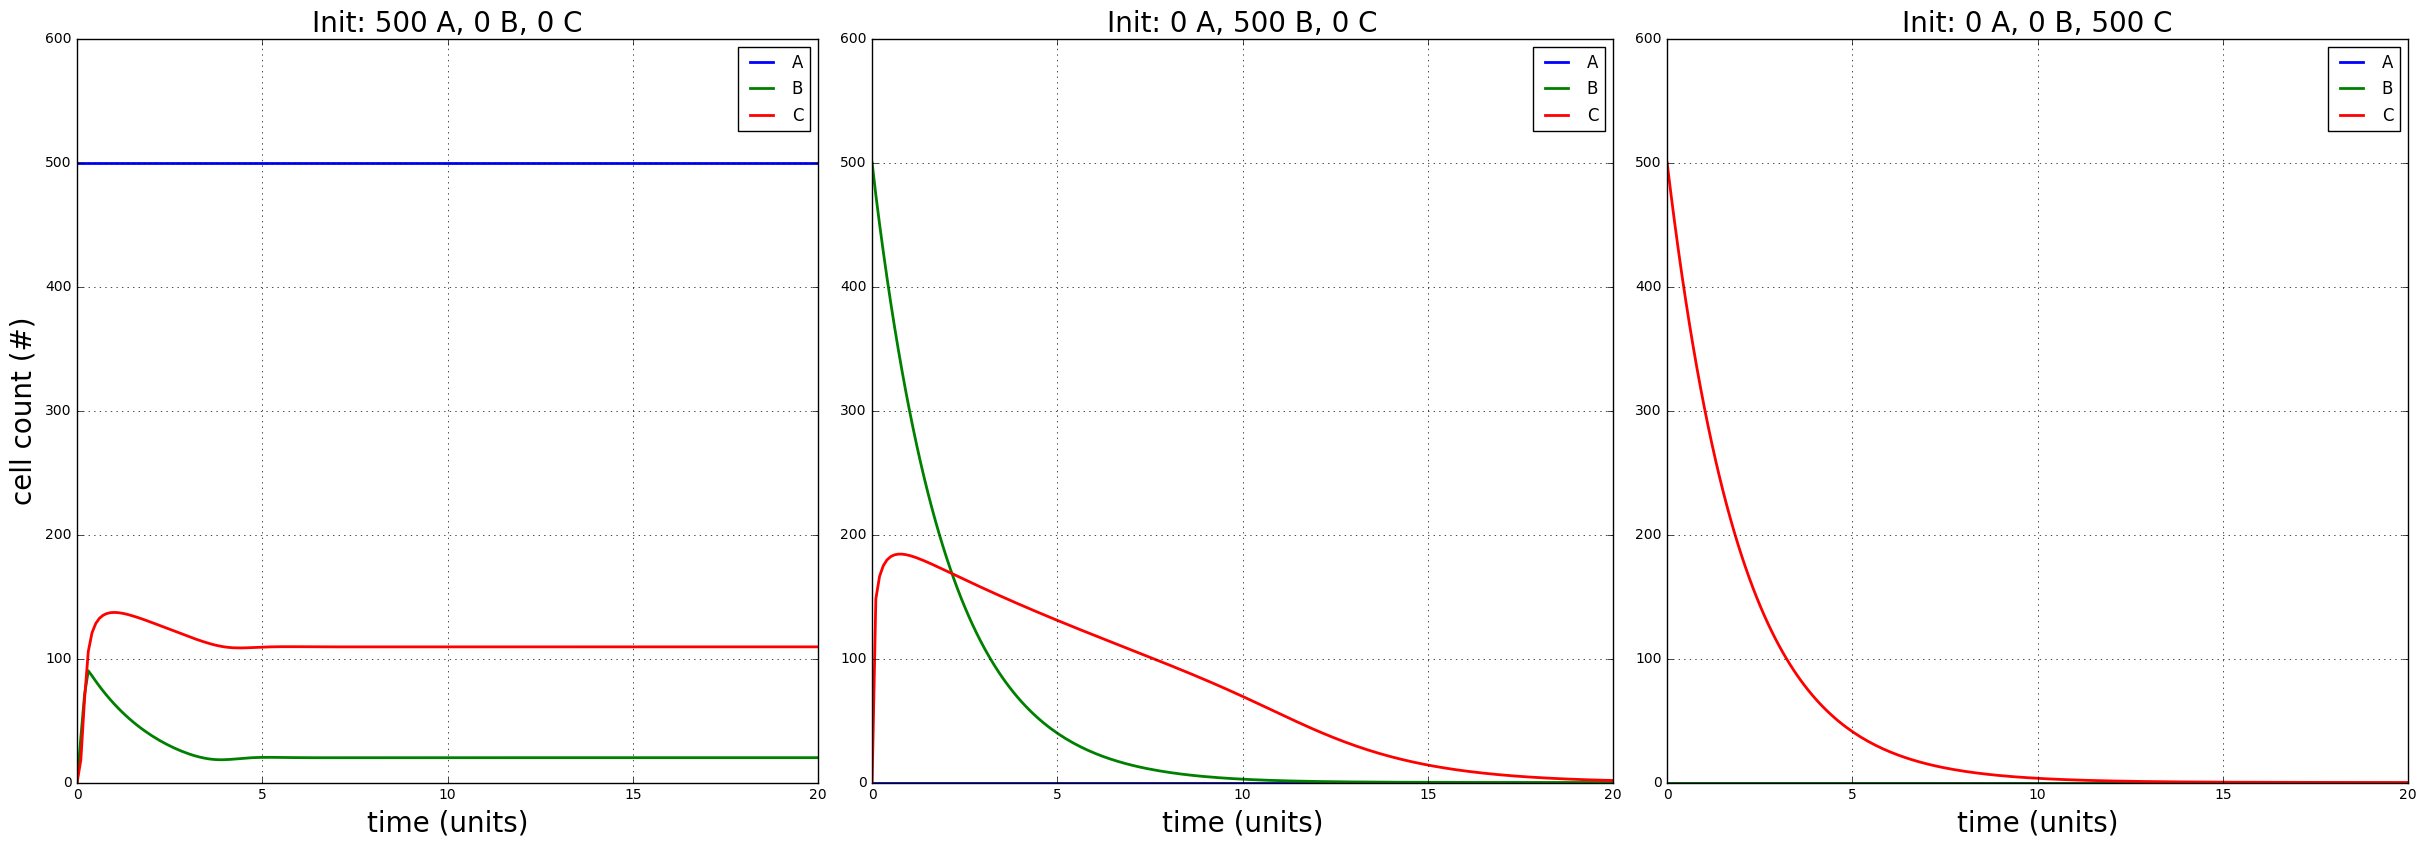

In [23]:
# calculate time
dt = 0.1
steps = 200
time = np.linspace(0.0, dt*steps, steps)

#declare model
def solver(y,t):
    A, B, C = y
    
    #feedbacks:
    fC2A = kC0A / (1 + (C/KC0A)**nC0A)
    fC2B = kC0B / (1 + (C/KC0B)**nC0B)

    #EQUATIONS:
    dAdt = kA2A*A - kA2X*A
    dBdt = kA2B*A*fC2A - kB2C*B*fC2B - kB2X*B
    dCdt = 100*kB2C*B*fC2B - kC2X*C

    return [dAdt, dBdt, dCdt]

#initialize plot
fig, axes = plt.subplots(1, 3, figsize=(24,8))
fig.tight_layout()
plot_titles = ['Init: 500 A, 0 B, 0 C', 'Init: 0 A, 500 B, 0 C', 'Init: 0 A, 0 B, 500 C']

#evaluate all initial starting conditions
for i in range(len(arr_init_conds)):
    # set initial conditions
    y0 = arr_init_conds[i]
    
    #solve odes:
    odes = odeint(solver, y0, time)
    arrA = odes[:,0]
    arrB = odes[:,1]
    arrC = odes[:,2]
    
    #plot
    axes[i].plot(time, arrA, 'blue', lw=2, label='A')
    axes[i].plot(time, arrB, 'green', lw=2, label='B')
    axes[i].plot(time, arrC, 'red', lw=2, label='C')
    axes[i].set_title(plot_titles[i], fontsize=20)
    axes[i].set_xlabel('time (units)', fontsize=20)
    if i == 0:
        axes[i].set_ylabel('cell count (#)', fontsize=20)
    axes[i].legend(loc=1)
    axes[i].grid()
    axes[i].set_ylim([0,600])


That looks good, but let's make it harder for our EA and say our experimentalist can't differentiate between cell types and can only count the total number of the cells for each experiment.  

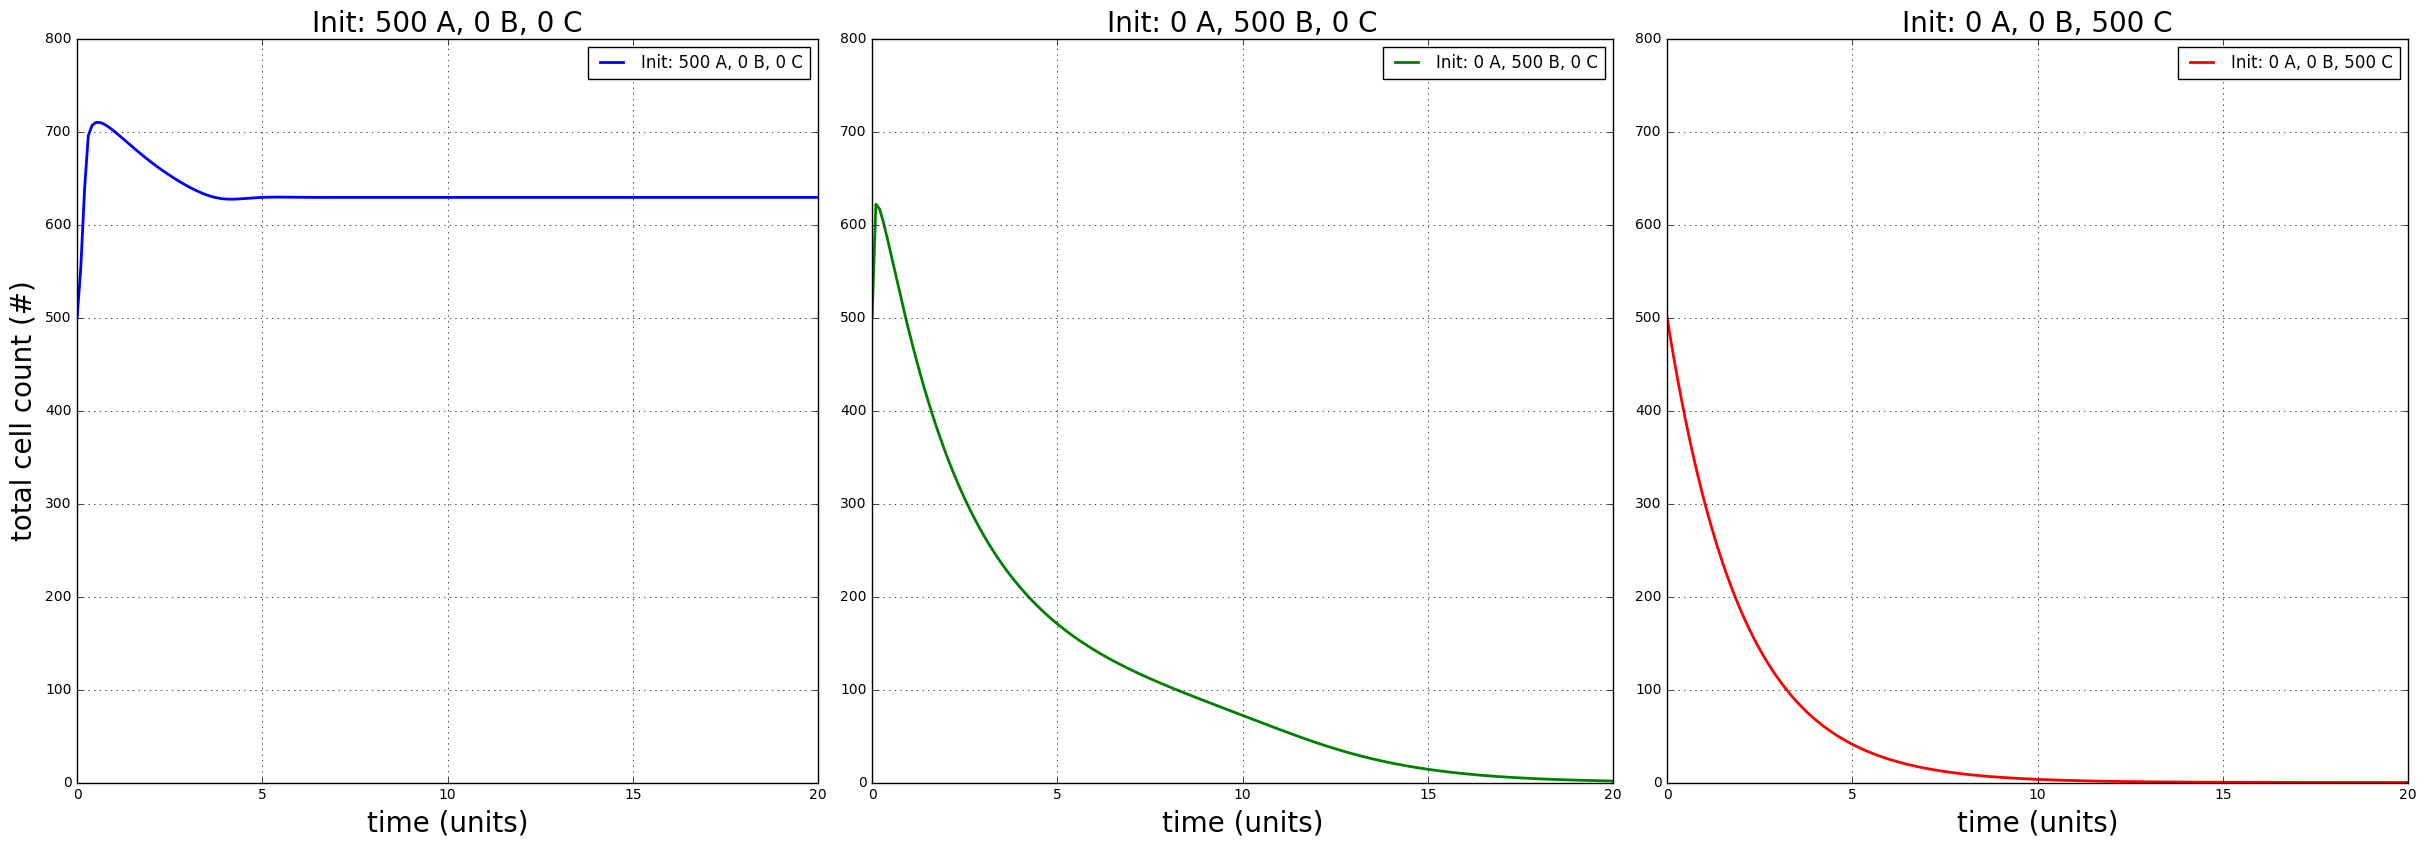

In [24]:
#initialize plot
fig, axes = plt.subplots(1, 3, figsize=(24,8))
fig.tight_layout()
plot_titles = ['Init: 500 A, 0 B, 0 C', 'Init: 0 A, 500 B, 0 C', 'Init: 0 A, 0 B, 500 C']
plot_colors = ['b','g','r']

#evaluate all initial starting conditions
for i in range(len(arr_init_conds)):
    # set initial conditions
    y0 = arr_init_conds[i]
    
    #solve odes:
    odes = odeint(solver, y0, time)
    arr_sum = np.sum(odes, axis=1)
    
    #plot
    axes[i].plot(time, arr_sum, color=plot_colors[i], lw=2, label=plot_titles[i])
    axes[i].set_title(plot_titles[i], fontsize=20)
    axes[i].set_xlabel('time (units)', fontsize=20)
    if i == 0:
        axes[i].set_ylabel('total cell count (#)', fontsize=20)
    axes[i].legend(loc=1)
    axes[i].grid()
    axes[i].set_ylim([0,800])


That also looks good, but let's make it a little harder on our EA and say our experimentalist can only count cells at 10 time points arbitrarily spaced part. This is more realistic anyway. 

In [25]:
# make synthetic "measured" array and plot points
num_synthetic_points = 10
idx_synthetic_points = np.linspace(0,100, num=num_synthetic_points, 
                                   endpoint=False, dtype=int)
scorefxn_time = time[[idx_synthetic_points]]
scorefxn_data = []

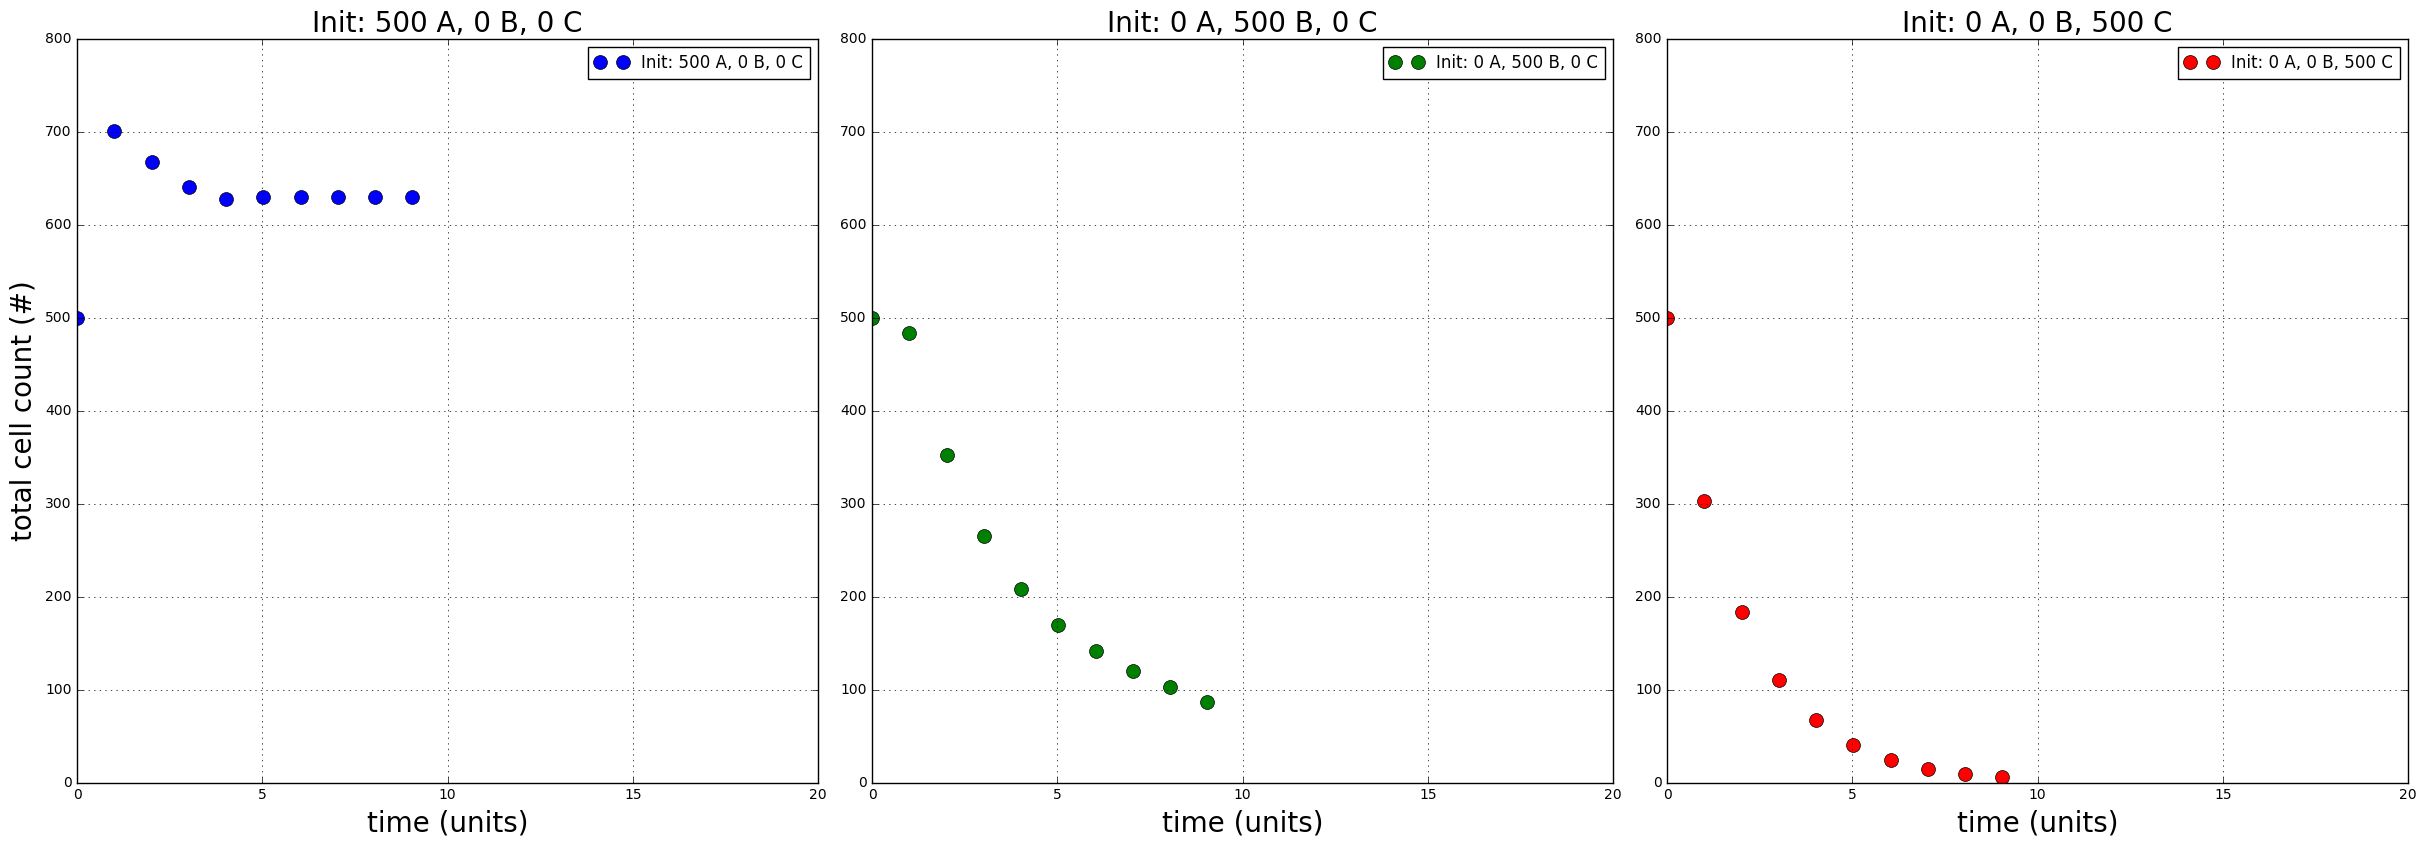

In [26]:
#initialize plot
fig, axes = plt.subplots(1, 3, figsize=(24,8))
fig.tight_layout()
plot_titles = ['Init: 500 A, 0 B, 0 C', 'Init: 0 A, 500 B, 0 C', 'Init: 0 A, 0 B, 500 C']
plot_colors = ['b','g','r']

#evaluate all initial starting conditions
for i in range(len(arr_init_conds)):
    # set initial conditions
    y0 = arr_init_conds[i]
    
    #solve odes:
    odes = odeint(solver, y0, time)
    arr_sum = np.sum(odes, axis=1)
    #append to array:
    scorefxn_data.append(arr_sum[[idx_synthetic_points]])
    
    #plot
    axes[i].plot(scorefxn_time, scorefxn_data[i], 'o', markersize=10, color=plot_colors[i], label=plot_titles[i])
    axes[i].set_title(plot_titles[i], fontsize=20)
    axes[i].set_xlabel('time (units)', fontsize=20)
    if i == 0:
        axes[i].set_ylabel('total cell count (#)', fontsize=20)
    axes[i].legend(loc=1)
    axes[i].grid()
    axes[i].set_ylim([0,800])
    axes[i].set_xlim([0,20])

That's better. Let's save our data. Note: these data points are all that our EA will see to learn the feedback parameters. 

In [27]:
scorefxn_arr = [scorefxn_time, scorefxn_data]

import pickle
filename = '/home/iammoresentient/phd_lab/data/161101_75-95-25-10-90-5.pickled'
pickle.dump(scorefxn_arr, open(filename, 'wb'))


**Recall:**  

Simple model with the following setup:   
- negative feedbacks from C to B and C to A  
- trying to learn feedback parameters from sum of all cells at multiple time points (simplest to implement, hardest for EA to learn from)  


Rationale: this is a similar (albeit simplified) setup to experimental data, both in vitro and in vivo transplant. I.E.:   
- transplant 500 of a self-renewable cell, like HSC --> sustained hematopoiesis  
- transplant 500 of a more differentiated cell, like MPP --> temporary hematopoiesis, then peters off as non-renewable MPP die off   

## Evolutionary algorithm

We will be using the excellent DEAP library for this portion of the tutorial.  

<https://github.com/DEAP/deap>

If you are completely unfamiliar with evolutionary algorithms, I would recommend checking out their excellent introductory tutorials:  

<https://deap.readthedocs.io/en/master/>

It is not included with anaconda, so you will need to download it separately. Depending on your setup it can be as easy as:  
```
pip install deap
```

First, we need to import a few packages from the DEAP library. 

In [28]:
from deap import base, creator, tools, algorithms

Let's load in our previously created data and double check that it is appropriate by plotting it. Note: these data points are all that our EA will see to learn the feedback parameters. 

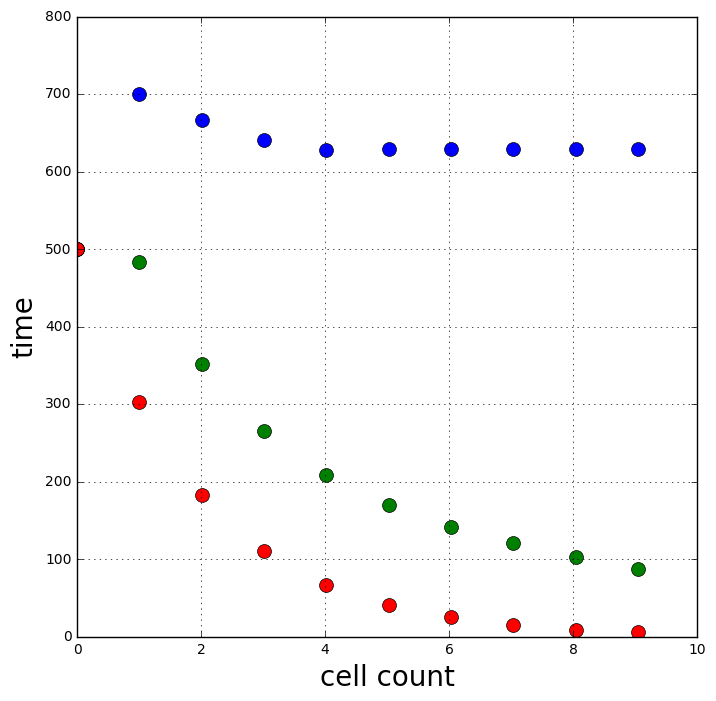

In [29]:
scorefxn_arr = []
scorefxn_time = []
scorefxn_data = []

filename = '/home/iammoresentient/phd_lab/data/161101_75-95-25-10-90-5.pickled'
scorefxn_arr = pickle.load(open(filename, 'rb'))
scorefxn_time, scorefxn_data = scorefxn_arr 

fig, axes = plt.subplots(1, 1, figsize=(8,8))
use_consistent_colors = ['b','g','r']
for idx, each_cond in enumerate(scorefxn_data):
    axes.plot(scorefxn_time, each_cond, 'o', markersize=10, color=use_consistent_colors[idx])
axes.set_ylabel('time', fontsize=20)
axes.set_xlabel('cell count', fontsize=20)
axes.grid()

These are the same values as above, but let's store them in arrays for now

In [45]:
# rates: leave these constant for now
# kA2A, kA2X, kA2B, kB2X, kB2C, kC2X
arr_synthetic_rates = [2,2,0.01,0.5,0.01,0.5]

# feedbacks: these will be learned
# kC0A, KC0A, nC0A, kC0B, KC0B, nC0B
arr_synthetic_feedbacks =[75,95,25,10,90,5]

# initial conditions, for each: [A,B,C]
arr_init_conds = np.array([[500,0,0],[0,500,0],[0,0,500]])

# time steps to check in ODE solver:
dt = 0.1
steps = 200
time = np.linspace(0.0, dt*steps, steps)

Now we need to write the various functions... 

In [31]:
def plot_synthetic_data():
    #fig, ax = plt.subplots(1, 1, figsize=(12,12))
    use_consistent_colors = ['b','g','r']

    for idx, data in enumerate(scorefxn_data):
        plt.plot(scorefxn_time, data, 'o', markersize=10,
                 color=use_consistent_colors[idx])

In [32]:
def get_rand_num():
    #np.around(np.random.rand(6)*100, decimals=1).tolist()
    number = 0.0
    while number == 0.0:
        number = round(np.random.rand()*100,0)
    return number 

In [33]:
def simulate_single_experiment1(init_conds, arr_rates, arr_feedbacks, time):
    # initial conditions:
    y0 = init_conds 
    # rates: leave these constant for now
    kA2A, kA2X, kA2B, kB2X, kB2C, kC2X = arr_rates
    # feedbacks: these are being learned in this case:
    kC0A, KC0A, nC0A, kC0B, KC0B, nC0B = arr_feedbacks
    
    #declare model
    def solver(y,t):
        A, B, C = y
        #feedbacks:
        fC2A = kC0A / (1 + (C/KC0A)**nC0A)
        fC2B = kC0B / (1 + (C/KC0B)**nC0B)
        #EQUATIONS:
        dAdt = kA2A*A - kA2X*A
        dBdt = kA2B*A*fC2A - kB2C*B*fC2B - kB2X*B
        dCdt = 100*kB2C*B*fC2B - kC2X*C
        
        return [dAdt, dBdt, dCdt]

    #solve odes:
    odes = odeint(solver, y0, time)
    arrA = odes[:,0]
    arrB = odes[:,1]
    arrC = odes[:,2]
    #arrSum = arrA+arrB+arrC
    
    # return array of individual cell counts:
    return odes

In [34]:
def scorefxn1(scorefxn_time, scorefxn_data, arr_init_conds, arr_synthetic_rates, 
             arr_feedbacks, time, plot_bool):
    # this is the custom score function for simple 3 cell model
    mse_total = 0
    # want to loop through all experimental data:
    for idx, experiment in enumerate(scorefxn_data):
        # simulate given the candidate feedback parameters:
        expX = simulate_single_experiment1(arr_init_conds[idx], arr_synthetic_rates, 
                                          arr_feedbacks, time)

        # for this particular experiment we need to sum all cell types:
        expX_sum = np.sum(expX, axis=1)

        # get index of time points closest 
        idx_closest_time_points = []
        for each_time in scorefxn_time:
            closest_idx = min(range(len(time)), 
                              key = lambda i: abs(time[i] - each_time))
            idx_closest_time_points.append(closest_idx)

        # use indexes of time points to get data points to score against
        expX_scorefxn_data = expX_sum[[idx_closest_time_points]]

        #SCORE IT! using MSE
        expX_mse = ((scorefxn_data[idx] - expX_scorefxn_data)**2).mean()
        #print('MSE Exp' + str(idx+1) + ': ', expX_mse)
        mse_total += expX_mse
        
        #plot for visualization:
        if plot_bool == True:
            use_consistent_colors = ['b','g','r']
            plt.plot(time,expX_sum, color=use_consistent_colors[idx], alpha=0.5)

    return mse_total

In [35]:
def scorefxn_helper(individual):
    # just a helper function that pulls all of scorefxn1 dependencies together
    # note the (), <--using single optimization in DEAP for now
    # scorefxn1 is taking care of the multiple optimizations for now
    return scorefxn1(scorefxn_time, scorefxn_data, arr_init_conds, 
                    arr_synthetic_rates, individual, time, False),

Evolutionary algorithm

In [47]:
#TYPE
#Create minimizing fitness class w/ single objective:
creator.create('FitnessMin', base.Fitness, weights=(-1.0,))
#Create individual class:
creator.create('Individual', list, fitness=creator.FitnessMin)

#TOOLBOX
toolbox = base.Toolbox()
#Register function to create a number in the interval [1-100?]:
toolbox.register('rand_num', get_rand_num)
#Register function to use initRepeat to fill individual w/ n calls to rand_num:
toolbox.register('individual', tools.initRepeat, creator.Individual, 
                 toolbox.rand_num, n=6)
#Register function to use initRepeat to fill population with individuals:
toolbox.register('population', tools.initRepeat, list, toolbox.individual)

#EVALUATION FUNCTION:
#Will use scorefxn1() here 

#GENETIC OPERATORS:
# Register evaluate fxn = evaluation function, individual to evaluate given later
toolbox.register('evaluate', scorefxn_helper)
# Register mate fxn = two points crossover function 
toolbox.register('mate', tools.cxTwoPoint)
# Register mutate by swapping two points of the individual:
toolbox.register('mutate', tools.mutPolynomialBounded, eta=10, low=0.1, up=100.0, indpb=0.2)
# Register select = size of tournament set to 3
toolbox.register('select', tools.selTournament, tournsize=3)

#EVOLUTION!
pop = toolbox.population(n=100)
hof = tools.HallOfFame(1)

stats = tools.Statistics(key = lambda ind: [ind.fitness.values, ind])
stats.register('all', np.copy)

# using built in eaSimple algo
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.5, ngen=100, 
                                    stats=stats, halloffame=hof, verbose=False)

print('Best individual is: %s\nwith fitness: %s' % (hof[0], hof[0].fitness))

Best individual is: [97.56448833881268, 92.07817629132255, 22.331603390530294, 12.77769786827993, 82.52659665558518, 4.737761058039343]
with fitness: (0.30227323535386308,)


In this demo run I got a sum of mean squared error (MSE) of 0.30 which is very very good for this system. Because of the stochastic nature evolutionary algorithms I would usually expect to see such a well performing run after several simulations. YMMV.

Regardless, we do not want to stop with a single well-performing run in a large search space.

Let's see how we did with a single run:

In [48]:
labelnames = ['kC0A', 'KC0A', 'nC0A', 'kC0B', 'KC0B', 'nC0B']

for i in range(len(hof[0])):
    temp_diff = ( np.abs(hof[0][i] - arr_synthetic_feedbacks[i]) / arr_synthetic_feedbacks[i]) * 100
    print(labelnames[i] + ': target = %0.2f, ea = %0.2f, perc diff = %0.2f %%' \
          %(arr_synthetic_feedbacks[i], hof[0][i], temp_diff))

kC0A: target = 75.00, ea = 97.56, perc diff = 30.09 %
KC0A: target = 95.00, ea = 92.08, perc diff = 3.08 %
nC0A: target = 25.00, ea = 22.33, perc diff = 10.67 %
kC0B: target = 10.00, ea = 12.78, perc diff = 27.78 %
KC0B: target = 90.00, ea = 82.53, perc diff = 8.30 %
nC0B: target = 5.00, ea = 4.74, perc diff = 5.24 %


Let's do a little bookkeeping so we can plot the data. Keep in mind we had 100 individuals over 100 generations:  
- arr_best_score finds the fittest individual in each generation's fitness score (sum of mean squared error (MSE))  
- arr_best_ind finds the fittest individual in each generation's set of feedback parameters  

In [49]:
# Find best scores and individuals in population 
arr_best_score = []
arr_best_ind = []
for a in range(len(logbook)):
    scores = []
    for b in range(len(logbook[a]['all'])):
        scores.append(logbook[a]['all'][b][0][0])
    #print(a, np.nanmin(scores), np.nanargmin(scores))
    arr_best_score.append(np.nanmin(scores))
    arr_best_ind.append(logbook[a]['all'][np.nanargmin(scores)][1])

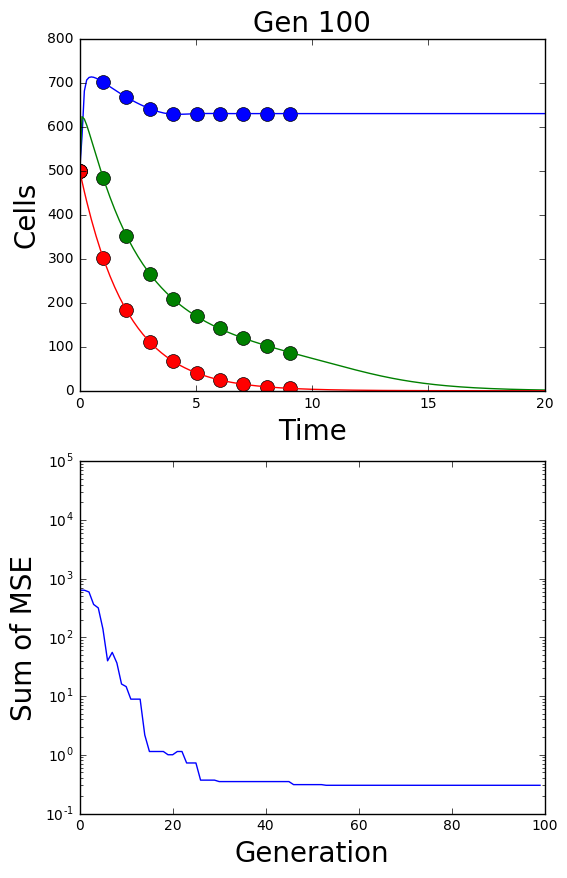

In [58]:
#select generation to plot [0,100]
gen = 100

#initialize figure:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(6,10))

#plot 1
title_text = 'Gen ' + str(gen)
ax1.set_title(title_text, fontsize=20)
ax1.set_xlabel('Time', fontsize=20)
ax1.set_ylabel('Cells', fontsize=20)
ax1.set_xlim([0,20])
ax1.set_ylim([0,800])
use_consistent_colors = ['b','g','r']
#plot synthetic data:
for idx, data in enumerate(scorefxn_data):
    ax1.plot(scorefxn_time, data, 'o', markersize=10,
             color=use_consistent_colors[idx])
#plot evolutionary algorithm data:
arr_feedbacks = arr_best_ind[gen]
for idx,init_conds in enumerate(arr_init_conds):
    expX = simulate_single_experiment1(init_conds, arr_synthetic_rates, 
                                          arr_feedbacks, time)
    expX_sum = np.sum(expX, axis=1)
    ax1.plot(time, expX_sum, color=use_consistent_colors[idx])

#plot2    
ax2.set_xlabel('Generation', fontsize=20)
ax2.set_ylabel('Sum of MSE', fontsize=20)
ax2.set_yscale('log')
ax2.set_xlim([0,100])
ax2.set_ylim([10**-1,10**5])
ax2.plot([x for x in range(gen)], arr_best_score[:gen])

In the top part of the plot above, the solid lines are the results of the fittest individual in the generation selected, gen 100 in this case. The dots are the training data. 

In the bottom part of the plot above, the x-axis is generations and the y-axis is fitness in log scale, sum of MSE in this case. The blue line is the fitness of the fittest individual in each generation. In early generations the fitness is terrible as the parameters are more random, but as the generations progress the fitness improves as our evolutionary strategy selects for well-performing parameters. Note we ran our simulation for a fixed number of generations, but could have stopped it much earlier (and optionally restarted) once it got stuck in a local minimum. Much like the dinosaurs got stuck in a local minima for 150 million years, maybe an asteroid should have obliterated them earlier. 

Overall our results aren't terrible and may be good enough to get an idea of the parameter values, but the real magic happens when we increase the number of EA runs, thereby sampling more of the parameter search space. 

### 20 runs 

I'm arbitrarily selecting 20 runs here, but you can run as many as you like, recognizing that how many you select will take approximately that many times longer than the single EA above if run on a single cpu. 

The code to do this is nearly identical to that above with two changes:  
- everything is wrapped in a for loop of 20 iterations in this case (embarassingly parallelizable) 
- the data from each iteration is pickled (saved) for later evaluation

In [60]:
for i in range(20):
    ###################################################################
    #EVOLUTIONARY ALGORITHM
    ###################################################################
    #TYPE
    #Create minimizing fitness class w/ single objective:
    creator.create('FitnessMin', base.Fitness, weights=(-1.0,))
    #Create individual class:
    creator.create('Individual', list, fitness=creator.FitnessMin)

    #TOOLBOX
    toolbox = base.Toolbox()
    #Register function to create a number in the interval [1-100?]:
    toolbox.register('rand_num', get_rand_num)
    #Register function to use initRepeat to fill individual w/ n calls to rand_num:
    toolbox.register('individual', tools.initRepeat, creator.Individual, 
                     toolbox.rand_num, n=6)
    #Register function to use initRepeat to fill population with individuals:
    toolbox.register('population', tools.initRepeat, list, toolbox.individual)

    #EVALUATION FUNCTION:
    #Will use scorefxn() here 

    #GENETIC OPERATORS:
    # Register evaluate fxn = evaluation function, individual to evaluate given later
    toolbox.register('evaluate', scorefxn_helper)
    # Register mate fxn = two points crossover function 
    toolbox.register('mate', tools.cxTwoPoint)
    # Register mutate by swapping two points of the individual:
    toolbox.register('mutate', tools.mutPolynomialBounded, eta=10, low=0.1, up=100.0, indpb=0.2)
    # Register select = size of tournament set to 3
    toolbox.register('select', tools.selTournament, tournsize=3)

    #EVOLUTION!
    pop = toolbox.population(n=100)
    hof = tools.HallOfFame(1)

    stats = tools.Statistics(key = lambda ind: [ind.fitness.values, ind])
    stats.register('all', np.copy)

    # using built in eaSimple algo
    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.5, ngen=100, 
                                        stats=stats, halloffame=hof, verbose=False)

    #print('Best individual is: %s\nwith fitness: %s' % (hof[0], hof[0].fitness))

    ###################################################################
    #MAKE LISTS
    ###################################################################
    # Find best scores and individuals in population 
    arr_best_score = []
    arr_best_ind = []
    for a in range(len(logbook)):
        scores = []
        for b in range(len(logbook[a]['all'])):
            scores.append(logbook[a]['all'][b][0][0])
        #print(a, np.nanmin(scores), np.nanargmin(scores))
        arr_best_score.append(np.nanmin(scores))
        arr_best_ind.append(logbook[a]['all'][np.nanargmin(scores)][1])

    ###################################################################
    #PICKLE
    ###################################################################
    arr_to_pickle = [arr_best_score, arr_best_ind]

    import os
    import os.path
    import pickle

    def get_filename(val):
        filename_base = '/home/iammoresentient/phd_lab/161020_ea_test_20runs/161020_data_'
        if val < 10:
            toret = '00' + str(val)
        elif 10 <= val < 100:
            toret = '0' + str(val)
        else:
            toret = str(val)
        return filename_base + toret + '.pickled'

    counter = 1
    filename = get_filename(counter)
    while os.path.isfile(filename) == True:
        counter += 1
        filename = get_filename(counter)
        if counter > 1000:
            break

    print(filename)
    pickle.dump(arr_to_pickle, open(filename,'wb'))


/home/iammoresentient/phd_lab/161020_ea_test_20runs/161020_data_001.pickled
/home/iammoresentient/phd_lab/161020_ea_test_20runs/161020_data_002.pickled
/home/iammoresentient/phd_lab/161020_ea_test_20runs/161020_data_003.pickled
/home/iammoresentient/phd_lab/161020_ea_test_20runs/161020_data_004.pickled
/home/iammoresentient/phd_lab/161020_ea_test_20runs/161020_data_005.pickled
/home/iammoresentient/phd_lab/161020_ea_test_20runs/161020_data_006.pickled
/home/iammoresentient/phd_lab/161020_ea_test_20runs/161020_data_007.pickled
/home/iammoresentient/phd_lab/161020_ea_test_20runs/161020_data_008.pickled
/home/iammoresentient/phd_lab/161020_ea_test_20runs/161020_data_009.pickled
/home/iammoresentient/phd_lab/161020_ea_test_20runs/161020_data_010.pickled
/home/iammoresentient/phd_lab/161020_ea_test_20runs/161020_data_011.pickled
/home/iammoresentient/phd_lab/161020_ea_test_20runs/161020_data_012.pickled
/home/iammoresentient/phd_lab/161020_ea_test_20runs/161020_data_013.pickled
/home/iammor

Now, let's load the data into arrays:

In [64]:
arr_best_scores = []
arr_best_inds = []
for i in range(1,21):
    if i < 10:
        filename = '/home/iammoresentient/phd_lab/161020_ea_test_20runs/161020_data_00'+str(i)+'.pickled'
    else:
        filename = '/home/iammoresentient/phd_lab/161020_ea_test_20runs/161020_data_0'+str(i)+'.pickled'
    arr_to_unpickle = pickle.load(open(filename,'rb'))
    arr_best_score, arr_best_ind = arr_to_unpickle
    arr_best_scores.append(arr_best_score)
    arr_best_inds.append(arr_best_ind)

# get data in proper voilin form:
arrT_best_inds = np.asarray(arr_best_inds).transpose()
arr_kC0A, arr_KC0A, arr_nC0A, arr_kC0B, arr_KC0B, arr_nC0B = arrT_best_inds

Plot and save images of the data at each generation. Because we have multiple EA runs here, we have added a third violin plot where we can see the distribution of parameters and watch them improve over generations. 

In [65]:
def get_gen_zeros(val):
    if val < 10:
        toret = '00' + str(val)
    elif 10 <= val < 100:
        toret = '0' + str(val)
    else:
        toret = str(val)
    return toret
    
#PLOT!
for gen in range(len(arr_best_scores[0])):
#gen = 50

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,15))

    for arr_best_score, arr_best_ind in zip(arr_best_scores, arr_best_inds):
    #recall: arr_best_scores & arr_best_inds len == 20
        #plot 1
        title_text = 'Gen ' + get_gen_zeros(gen)
        ax1.set_title(title_text, fontsize=20)
        ax1.set_xlabel('Time', fontsize=20)
        ax1.set_ylabel('Cells', fontsize=20)
        ax1.set_xlim([0,20])
        ax1.set_ylim([0,800])
        use_consistent_colors = ['b','g','r']
        #plot synthetic data:
        for idx, data in enumerate(scorefxn_data):
            ax1.plot(scorefxn_time, data, 'o', markersize=10,
                     color=use_consistent_colors[idx])
        #plot evolutionary algorithm data:
        arr_feedbacks = arr_best_ind[gen]
        for idx,init_conds in enumerate(arr_init_conds):
            expX = simulate_single_experiment1(init_conds, arr_synthetic_rates, 
                                                  arr_feedbacks, time)
            expX_sum = np.sum(expX, axis=1)
            ax1.plot(time, expX_sum, color=use_consistent_colors[idx])

        #plot2: MSE vs generations     
        ax2.set_xlabel('Generation', fontsize=20)
        ax2.set_ylabel('Sum of MSE', fontsize=20)
        ax2.set_yscale('log')
        ax2.set_xlim([0,100])
        #ax2.set_ylim([0,max_y_val])
        ax2.set_ylim([10**-1,10**5])
        ax2.plot([x for x in range(gen)], arr_best_score[:gen])

    #plot3: violin plots     
    #arr_kC0A, arr_KC0A, arr_nC0A, arr_kC0B, arr_KC0B, arr_nC0B = arrT_best_inds
    locs = [1,2,3,4,5,6]
    #actual_vals = [10,10,2,10,90,2]
    actual_vals = [75,95,25,10,90,2]
    labelnames = ['kC0A', 'KC0A', 'nC0A', 'kC0B', 'KC0B', 'nC0B']
    pts = 100
    wds = 0.90

    #violin plots:  
    ax3.violinplot(arr_kC0A[gen], [1], points=pts, widths=wds, showmeans=True)
    ax3.violinplot(arr_KC0A[gen], [2], points=pts, widths=wds, showmeans=True)
    ax3.violinplot(arr_nC0A[gen], [3], points=pts, widths=wds, showmeans=True)
    ax3.violinplot(arr_kC0B[gen], [4], points=pts, widths=wds, showmeans=True)
    ax3.violinplot(arr_KC0B[gen], [5], points=pts, widths=wds, showmeans=True)
    ax3.violinplot(arr_nC0B[gen], [6], points=pts, widths=wds, showmeans=True)

    #plot actual values:
    ll = 0.4
    for loc, aval in zip(locs,actual_vals):
        ax3.plot([loc-ll,loc+ll], [aval,aval], 'g', lw=5)

    ax3.set_xticks(locs)
    ax3.set_xticklabels(labelnames, fontsize=20)
    ax3.set_ylim([-10,110])
    ax3.set_xlabel('Learned parameters', fontsize=20)
    ax3.set_ylabel('Learned parameter values', fontsize=20)

    fig.tight_layout()


    #filename:
    if gen < 10:
        filename = '161020_image_00' + str(gen)
    elif 10 <= gen < 100:
        filename = '161020_image_0' + str(gen)
    else:
        filename = '161020_image_' + str(gen)
    fig.savefig('/home/iammoresentient/phd_lab/161020_ea_test_20runs/' + filename + '.jpg')

    fig.clf()

/home/iammoresentient/bin/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Turn those plots into a gif using ImageMagick.

In [66]:
# large animation
filename = '/home/iammoresentient/phd_lab/161020_ea_test_20runs/161020_anim_001.gif'
command1 = 'convert -delay 20 -loop 0 /home/iammoresentient/phd_lab/161020_ea_test_20runs/161020_image* ' + filename
os.system(command1)

0

Again, use ImageMagick to make a reasonably sized gif. 

In [67]:
# small animation
filename_small = '/home/iammoresentient/phd_lab/161020_ea_test_20runs/161020_anim_001_small.gif'
command2 = 'convert -size 1000x1500 ' + filename + ' -resize 400x600 ' + filename_small
os.system(command2)
command3 = 'convert ' + filename_small + ' -dither none -deconstruct -colors 32 ' + filename_small
os.system(command3)

0

Show the animation!

In [8]:
#Code to plot an animation:
from IPython.display import Image
Image(url='./161020_ea_test_20runs/161020_anim_001_small.gif')


In the upper frame of the plot above, the solid lines are the results of the fittest individual in the generation selected, gen 100 in this case. The dots are the training data. 

In the middle frame of the plot above, the x-axis is generations and the y-axis is fitness in log scale, sum of MSE in this case. The fitness of each EA improves over generations, until they get stuck in local minima, but with 20 runs we can see the distribution of error (sum of MSE) -- from about 0.1 to 100.

In the lower frame of the plot above, we are looking at violin plots of each of the 6 parameters we are letting the EA fit. The y-axis is the range of values the EA can sample from for each parameter (0-100) and the green lines are the known parameter values we used to generate the synthetic data. 

Our results aren't terrible, but they're far from what we are capable of. However, we're getting closer to the real magic.

### 1000 runs 

Now, using the same methodology as above, let's see how 1000 runs improves our results. Like selecting 100 individuals and 100 generations, 1000 runs is arbitrary and unoptimized for this example -- it simply allows us to improve our results by sampling a larger search space. EAs approach 0 error as the number of parameter sets sampled approaches the total number of possible combinations. As described above:

- If we assume the six feedback parameter can each take 1000 different values:  
$$1000^6 = 10^{18} \text{ possible combinations} $$  
- Later in this example we will perform:  
$$\frac{1000 \text{ EA runs} }{} \times \frac{100 \text{ generations} }{\text{EA run}} \times \frac{100 \text{ individuals} }{\text{generation}} = 10^7 \text{ sampled combinations}$$
- Or:  
$$ \frac{10^7}{10^{18}} = 10^{-11} \times 100\% = 0.000000001\% \text{ of possible combinations sampled}$$  

Depending on your machine each EA run will take approximately 2 minutes:  
- Total run time for this unoptimized EA on a single cpu is (this is highly parallelizable):  
$$\frac{1000 \text{ EA runs} }{} \times \frac{\sim 2 \text{ minutes} }{\text{EA run}} = \sim 33 \text{ hours}$$  
- Total run time to brute force every possible combination in a similar manner is:  
$$\frac{10^{18} \text{ possible combinations} }{} \times \frac{\text{ EA runs} }{100 \text{ generations}} \times \frac{\text{ generation} }{100 \text{ individuals}} = 10^{14} \text{ EA runs}$$  
$$\frac{10^{14} \text{ EA runs} }{} \times \frac{\sim 2 \text{ minutes} }{\text{ EA run}} \times \frac{\text{ hour} }{60 \text{ minutes}} \times \frac{\text{ days} }{24 \text{ hours}} \times \frac{\text{ years} }{365 \text{ days}} = \sim 380 \text{ million years}$$  

I ran the 1000 EAs simulation on a 100 cpu high performance cluster in approximately 20 minutes. I spent no time optimizing this simple model, but there are a number of optimization strategies possible (including some very obvious ones for this example) that I will perhaps cover in a later notebook.  

Now, following the same steps as above, let's take a look at our results with a small animation. 

In [1]:
#Code to plot an animation:
from IPython.display import Image
Image(url='./161105_ea_test_1000runs/161103_anim_001_small.gif')

Despite performing 50x more EAs the distributions of our learned parameters (lower plot above) doesn't converge on the known parameter values we used to create the synthetic data (green lines in the lower plot above) any better than the above example with only 20 EAs. Why not?  

Whether using 20 EAs or 1000 EAs, we expect to get back similar distributions of the sum of MSE (middle frame in the plot above). So what's the point of running more EAs?  

By performing more EAs, we now have more EAs performing as well as or better than the best performing solution from our 20 EA simulation. The best performing solution from our 20 EA simulation had a sum of MSE of approximately 0.25.  Our 1000 EA simulation has 63 solutions with a lower sum of MSE than 0.25. (Another note on optimization: how many EAs to run is up for discussion, but is related to how exact of a solution one is looking for with the caveat of diminishing returns (kind of)).

Let's take a look at just those high performing solutions with a small animation.

In [13]:
#Code to plot an animation:
from IPython.display import Image
Image(url='./161105_ea_test_1000runs/161103_best_anim_001_small.gif')

As we can see the distributions of our learned parameters (lower frame in the plot above) converges on the known parameter values we used to create the synthetic data (green lines in the lower frame of the plot above). We also note they converge quickly (insert another statement about optimization here).  

Because we created synthetic data with known parameter values for these simulations we can see how close our learned paramter values got to the known:  
```
kC0A: target = 75.00, ea = 73.65 +/- 7.81, perc diff = 1.80 %
KC0A: target = 95.00, ea = 96.07 +/- 2.76, perc diff = 1.12 %
nC0A: target = 25.00, ea = 28.00 +/- 5.59, perc diff = 12.00 %
kC0B: target = 10.00, ea = 10.08 +/- 0.94, perc diff = 0.81 %
KC0B: target = 90.00, ea = 89.99 +/- 2.57, perc diff = 0.01 %
nC0B: target = 5.00, ea = 5.01 +/- 0.08, perc diff = 0.13 %
```   
For 5 / 6 parameters we are remarkably successful at learning the parameter values, despite:
- sampling only 0.000000001% of parameter space in a nonlinear system  
- being given only the total number of cells at a few time points  
- using a completely unoptimized EA  

What happened with parameter $\text{n}_{\text{C0A}}$? This is largely a function of using a decreasing hill function because n represents the steepness of the function. As n's value increases it becomes increasingly difficult to differentiate between two numbers -- between say 25 and 26 or even between 25 and 30 (as shown below). In practice this value should be contrained below approximately 10: 
$$\frac{ \text{k}_{\text{C0A}} }{ \bigg( 1 + \big( \frac{ \text{C} }{ \text{K}_{\text{C0A}} } \big) ^ { \text{n}_{\text{C0A}} } \bigg) } $$

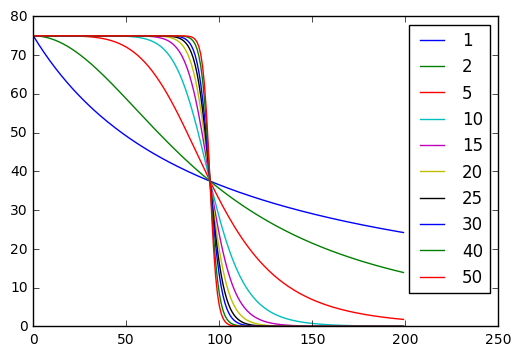

In [14]:
%matplotlib inline
nC0A = [1,2,5,10,15,20,25,30,40,50]
x = np.arange(0,200)
for n in nC0A:
    y = 75 / ( 1 + (x/95)**n)
    plt.plot(x,y, label=str(n))
plt.xlim(0,250)    
plt.legend()

## Summary

I hope this brief introduction to modeling biological systems and fitting parameters with EAs has been useful. This has been intended as a primer, much more complex things are possible. Stay tuned for future notebooks covering similar topics. 

The end